# This simulates 2D acquisition of k-space with frequency and phase encoding gradients (simple epi)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import csv
import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr
from scipy.special import stdtr
import csv
import pandas as pd

import sys 
import os

import tkinter as tk
from tkinter import ttk


In [2]:
def yMagnitude(dB,gamma,t,phi): #define M_y in rotating frame
    w0 = 0# (for relative phase, set it to zero)
    w =dB*gamma #larmor frequency in cycle/second
    M = np.cos(2*np.pi*w*t + phi) # it's rotating in a circle
    return M

# given gradient along x (frequency-encoding), gamma, and amount of time gradient is on
# return the signal per time along that x-axis
def setFreqGradient(Bxs,gamma,t): #do this for different delta B (i.e. gradient compared to center B =0)
    Ms = [] #all My for a particular time t, for all Bs in a row
    for i in range(len(Bxs)):
        Mi = yMagnitude(Bxs[i],gamma,t,0) #get value at given time t for a certain dB (which is function of location along x), and phi = 0 bc no phase assumed
        Ms.append(Mi)
    return Ms

# for 1D
def run1D(Bs,gamma,ts): #do this for a set of times! (i.e. let it sit for t seconds..)
    Myts = [] #all Mys for all Bs, for all ts
    for i in range(len(ts)):
        Myt= setFreqGradient(Bs,gamma,ts[i])
        Myts.append(Myt)
    return Myts

# given signal along x, gradient strength along y (phase-encoding), gamma, and amount of time gradient is on
# return 2D signal per time along x and y axes. 
def setPhaseGradient(Bxs,Bys,gamma,t,t_phase):
    Ms = np.zeros((len(Bxs),len(Bys))) # create 2D blank map
    for i in range(len(Bxs)): # for each position along x
        for j in range(len(Bys)): # for each phase encoding step
            phi = gamma * Bys[j]*t_phase #calculate phase accrued 
            Myi = yMagnitude(Bxs[i],gamma,t,phi)
            Ms[j][i] = Myi
    return Ms

def run2D(Bxs,Bys,gamma,t_phases,ts):
    Mijts = np.zeros((len(t_phases),len(ts),len(Bxs),len(Bys)))
    for j in range(len(t_phases)): #for each phase step
        for i in range(len(ts)): #run frequency encoding with phase gradient
            Mijts[j,i,:,:] = setPhaseGradient(Bxs,Bys,gamma,ts[i],t_phases[j])
    return Mijts
    

In [3]:
# for pretty
Bx = np.linspace(0,.4,201)
gamma = 1#rad/s*T
ts = np.linspace(0,10,9) #for 10 seconds
Ms = run1D(Bx,gamma,ts)

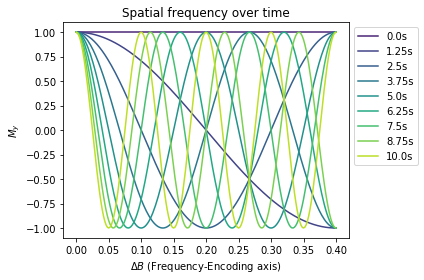

This shows the increasing spatial frequency (as a function of Delta B) over time!


In [4]:
for i in range(len(ts)):
    with sns.color_palette("viridis",len(ts)):
        pl.plot(Bx,Ms[i],label = str(ts[i])+'s')
pl.xlabel('$\Delta B$ (Frequency-Encoding axis)')
pl.ylabel('$M_y$')
pl.legend(bbox_to_anchor=(1, 1))
pl.title('Spatial frequency over time')
pl.tight_layout()
#pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq.png',format='png',dpi=120)
pl.show()

print('This shows the increasing spatial frequency (as a function of Delta B) over time!')

In [8]:
def yMagnitude_kspace(dB,gamma,t, phi): #define M_y in rotating frame
    w0 = 0# (for relative phase, set it to zero)
    w =dB*gamma #larmor frequency in cycle/second
    My = np.cos(2*np.pi*w*t-phi)
    return My

def setGradient_kspace(Bs,gamma,t, phis): #do this for different delta B (i.e. gradient compared to center B =0)
    Mys = [] #all My for a particular time t, for all Bs in a row
    for j in range(len(phis)):
        My_phis = []
        for i in range(len(Bs)):
            Myi = yMagnitude_kspace(Bs[i],gamma,t,phis[j])
            My_phis.append(Myi)
        Mys.append(My_phis)
    return Mys


def make_phis(gamma,Bs,n,t): #make n phis where phi = gamma Gy t, where t is the amount of time the gradient is on. Also relative to the RF frequency.
    phis = []
    #assume t = 1, gamma = 1
    Bx = np.linspace(min(Bs),max(Bs),n) #go from min to max of gradient, in n steps
    for i in range(n):
        phi = 2*np.pi*gamma*Bx[i]*t
        phis.append(phi)
    return phis
    
    
def run_kspace(Bs,gamma,ts, phis): #do this for a set of times! (i.e. let it sit for t seconds..)
    Myts = [] #all Mys for all Bs, for all ts
    for i in range(len(ts)):
        Myt= setGradient_kspace(Bs,gamma,ts[i],phis)
        Myts.append(Myt)
    return Myts


In [9]:
# for pretty
Bs2 = np.linspace(0,.4,201)

Bs3 = np.linspace(0,.01,201) #from no difference to +.2, needs to be half to avoid looping! (only \pi, not 2\pi)
gamma3 = 1#rad/s*T
ts3 = np.linspace(1,5,2) #for 10 seconds


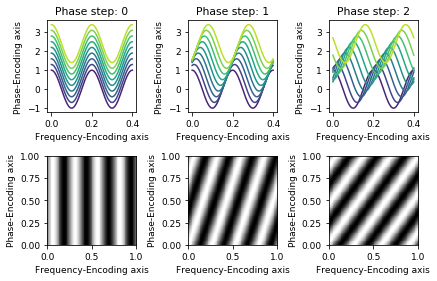

In [12]:
matplotlib.rcParams.update({'font.size': 9})
Gradient = [.001,.4,.8]
fig, axes = pl.subplots(2,3) 
angles = np.linspace(0,np.pi/5,3)
x = np.linspace(0,1,101)
X, Y = np.meshgrid(x, x)
for j in range(3):
    Bs3 = np.linspace(0,Gradient[j],201)
    phis3 = make_phis(1,Bs3,9,1)
    Ms3 = run_kspace(Bs2,gamma3,ts3, phis3)
    colors = sns.color_palette("viridis",len(phis3))
    for i in range(len(phis3)):
        axes[0,j].plot(Bs2,np.array(Ms3[1][i])+i*.3,label = f'$\phi_{i+1:.0f}$',color = colors[i])
    axes[0,j].set_xlabel('Frequency-Encoding axis')
    axes[0,j].set_ylabel('Phase-Encoding axis')
    axes[0,j].set_title('Phase step: '+f'{j:.0f}')
for k in range(len(angles)):
    tilt = angles[k]
    img = np.sin(2*np.pi*(X*np.cos(tilt) + Y*np.sin(tilt))*4)
    axes[1,k].imshow(img,cmap = 'gray',extent = [0,1,0,1])
    axes[1,k].set_xlabel('Frequency-Encoding axis')
    axes[1,k].set_ylabel('Phase-Encoding axis')
    #pl.legend(bbox_to_anchor=(1, 1))
    #pl.title('Phase-encoding rotating sinusoid')
pl.tight_layout()
#pl.savefig('/Users/neuroimaging/Desktop/Spatial_phase_2.png',format='png',dpi=120)
pl.show()


#print('This shows the increasing spatial frequency (as a function of Delta B) over time!')

# Showing kx and ky

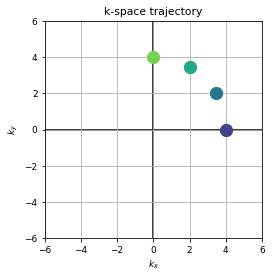

In [13]:
k = 4
phis3 = np.array([0,30,60,90])*np.pi/180 #In radians
kx = k*np.cos(phis3)
ky = k*np.sin(phis3)
for i in range(len(phis3)):
    with sns.color_palette("viridis",len(phis3)):
        pl.scatter(kx[i],ky[i],label = f'n = {i+1:.0f}',s=150,zorder=2)
        
pl.axhline(y=0,color = 'black',zorder=0)
pl.axvline(x=0,color = 'black',zorder=1)
pl.xlim(-6,6)
pl.ylim(-6,6)
pl.xlabel('$k_x$')
pl.ylabel('$k_y$')
pl.grid(True)
pl.gca().set_aspect('equal', adjustable='box')
pl.title('k-space trajectory')
#pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq_kspace_ky.png',format='png',dpi=120)

pl.show()

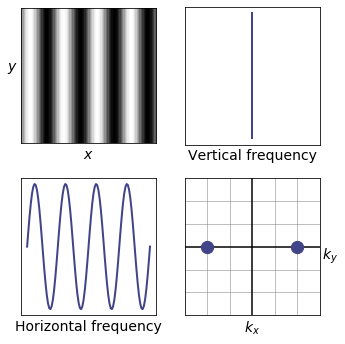

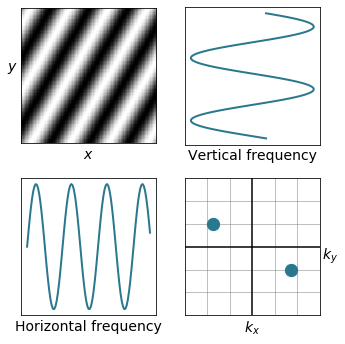

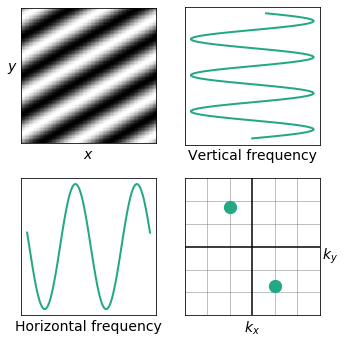

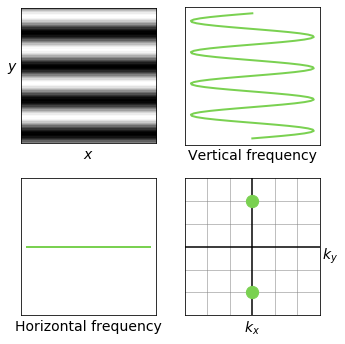

In [14]:
#x = np.arange(0, 101, 1)
matplotlib.rcParams.update({'font.size': 14})
x = np.linspace(0,1,101)
X, Y = np.meshgrid(x, x)
#ft_freq = np.linspace(-.5,.5,101)#kmax = 1/2Deltax, Delta kx = 1/FOVx
angles = np.linspace(0,np.pi/2,4)
colors = sns.color_palette("viridis",len(angles))
for i in range(len(angles)):
    fig, ((ax1, ax2),(ax3,ax4)) = pl.subplots(2,2,figsize = (5,5))
    pl.xticks([])
    pl.yticks([])
    #phi being the tilt angle
    tilt = angles[i]
    img = np.sin(2*np.pi*(X*np.cos(tilt) + Y*np.sin(tilt))*4)
    ax1.imshow(img,cmap = 'gray',extent = [0,1,0,1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.yaxis.set_label_position("left")
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$   ',rotation = 0)

    ax2.plot(img[:,100],x,color = colors[i],linewidth=2)
    ax3.plot(x,img[100,:],color = colors[i],linewidth=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel('Vertical frequency')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_xlabel('Horizontal frequency')
    #ft = np.fft.fft2(img)
    #kspace = np.fft.fftshift(ft) #moves zero frequency component to center
    #ax4.imshow(np.abs(kspace[25:-25,25:-25]),cmap = 'gray')
    ax4.scatter(kx[i],-ky[i],label = f'n = {i+1:.0f}',s=150,color = colors[i],zorder = 3)
    ax4.scatter(-kx[i],ky[i],label = f'n = {i+1:.0f}',s=150,color = colors[i],zorder = 3)
    pl.axhline(y=0,color = 'black',zorder=1)
    pl.axvline(x=0,color = 'black',zorder=1)
    pl.axhline(y=2,color = 'grey',zorder=0,linewidth=.5)
    pl.axvline(x=2,color = 'grey',zorder=0,linewidth=.5)
    pl.axhline(y=-2,color = 'grey',zorder=0,linewidth=.5)
    pl.axvline(x=-2,color = 'grey',zorder=0,linewidth=.5)
    pl.axhline(y=4,color = 'grey',zorder=0,linewidth=.5)
    pl.axvline(x=4,color = 'grey',zorder=0,linewidth=.5)
    pl.axhline(y=-4,color = 'grey',zorder=0,linewidth=.5)
    pl.axvline(x=-4,color = 'grey',zorder=0,linewidth=.5)
    pl.xlim(-6,6)
    pl.ylim(-6,6)
    #ax4.set_xticks([])
    #ax4.set_yticks([])
    ax4.yaxis.set_label_position("right")
    ax4.set_xlabel('$k_x$')
    ax4.set_ylabel('   $k_y$',rotation = 0)
    #ax4.grid(b=True,which = 'major')
    pl.tight_layout()
    pl.pause(.5)
    
    